# Entrenamiento del modelo NLP

### **Objetivo**

El objetivo de este notebook es detallar el proceso completo seguido para el entrenamiento de un modelo NLP capaz de detectar síntomas y las posibles deficiencias nutricionales asociadas al síntoma a partir de una descripción breve del estado de ánimo/físico del usuario. Esto es útil para después construir un recomendador de recetas que tome en cuenta tanto los ingredientes detectados con el modelo YOLO (construido en "2) Entrenamiento del modelo YOLO") así como las necesidades específicas del consumidor en cuanto a deficiencia nutricional.

Véase el siguiente ejemplo de cómo sería el flujo:
1) El usuario describe "últimamente me siento muy cansado todos los días"
2) El modelo NLP detecta que el síntoma es `fatiga`, un síntoma usualmente asociado a posibles deficiencias de `hierro, vitamina b12, folato, vitamina d y magnesio`
3) Algunos de los ingredientes que podrían ayudar con las deficiencias son: `carne vacuno, platano, salchichas, huevos, etc`
4) Sabemos de YOLO que el usuario tiene `huevos, plátano y tomates` en la nevera
5) El recomendador de recetas priorizará recetas con huevo, plátano ya que ayudan a cubrir posibles deficiencias nutricionales y a la vez utiliza ingredientes ya disponibles en la nevera.

**Cabe mencionar que el modelo no pretenderá sustituir el consejo médico, más bien es una herramienta para lidiar posiblemente con algunos síntomas padecidos. Pero siempre se debería priorizar el consejo médico profesional.**

## 1) Imports

In [70]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, EarlyStoppingCallback
)
import torch
import json
print(torch.cuda.is_available())  # True if GPU is accessible
print(torch.cuda.get_device_name(0))  # Name of GPU 0


True
NVIDIA RTX 2000 Ada Generation Laptop GPU


## 2) Construcción del dataset

Para poder entrenar un modelo NLP capaz de predecir síntomas en base a descripciones de los usuarios, es necesario primero obtener un set de datos cuya estructura sea como mínimo:
`Descripción -> Síntoma`.

En realidad, la estructura necesaria para que el dataset sea funcional y útil es la siguiente:

`Nota: los datos siguientes son solamente ejemplos`

| Descripción                  | Síntoma                         | Posibles deficiencias nutricionales | Ingredientes que suplen la deficiencia |
|------------------------------|---------------------------------|-------------------------------------|-----------------------------------------|
| ultimamente me noto cansado todo el dia y va a peor         | Fatiga       | hierro; vitamina b12; folato; vitamina d; magnesio               | carne vacuno, carne cerdo, carne pollo, carne pavo, salchichas, salmon, merluza, etc  |
| por las mananas casi no me da el sol y me duelen los musculos y me pasa a menudo               | deficit de vitamina d  | vitamina d              | salmon, merluza, lubina, gambas/langostinos, mix de marisco/molusco, huevos, champinones        |

Dado que no hay sets de datos públicos disponibles con la estructura mencionada, se ha decidido crear un set de datos manualmente recopilando fuentes médicas y combinándolos con sets de datos sintéticos. Se han utilizado fuentes médicas para el entendimiento y la información de deficiencias nutricionales así como los alimentos que podrían ayudar con los mismos. Adicionalmente, se ha utilizado Large Language Models como Chat GPT junto a invención propia para crear diferentes descripciones que describan estados de ánimo/física que puedan dar señales de posibles deficiencias nutricionales. En resumen:
- Se ha consultado con fuentes médicas para el entendimiento de deficiencias nutricionales e ingredientes que proveen dichos nutrientes (ejemplo de algunas fuentes de información: 
    - Información sobre alimentos y nutrientes: National Institutes of Health (NIH, US) https://ods.od.nih.gov/factsheets/list-all/?utm_source,
    - Información sobre síntomas y deficiencias nutricionales: https://my.clevelandclinic.org/health/diseases?q=deficiency&dFR[type][0]=diseases, https://www.yalemedicine.org/conditions, https://cpmedicalclinic.com/latest/the-most-common-nutrients-youre-missing-what-to-do-about-it/#:~:text=Q:%20How%20do%20you%20know,mood%20balancing%20and%20controlling%20inflammation) (buscando por la palabra "deficiency")
)
- Se han creado diferentes descripciones para síntomas y se ha utilizado LLMs como técnica de aumentación generando más descripciones similares para cada síntoma.

Básicamente, el flujo lógica sería el siguiente:
`Oración describiendo el estado físico/anímico -> Síntomas -> deficiencias nutricionales asociadas -> en qué alimentos se puede encontrar los nutrientes necesarios`

El set de datos final tiene la siguiente estructura.

In [71]:
sintomas_df = pd.read_csv(r'..\dataset\Nutritional deficiency dataset\deficiencies_dataset.csv')

In [72]:
sintomas_df.head()

,sintoma,texto,deficiencia de nutrientes,disponible en ingredientes,source
0,fatiga,estoy constantemente cansado y sin energia,hierro; vitamina b12; folato; vitamina d; magn...,"carne vacuno, carne cerdo, carne pollo, carne ...",original
1,fatiga,estoy constantemente fatigado y muy bajo de en...,hierro; vitamina b12; folato; vitamina d; magn...,"carne vacuno, carne cerdo, carne pollo, carne ...",parafraseado
2,fatiga,por las mananas estoy constantemente cansado y...,hierro; vitamina b12; folato; vitamina d; magn...,"carne vacuno, carne cerdo, carne pollo, carne ...",parafraseado
3,fatiga,de vez en cuando estoy constantemente sin ener...,hierro; vitamina b12; folato; vitamina d; magn...,"carne vacuno, carne cerdo, carne pollo, carne ...",parafraseado
4,fatiga,me siento agotado todo el dia,hierro; vitamina b12; folato; vitamina d; magn...,"carne vacuno, carne cerdo, carne pollo, carne ...",original


Podemos observar que los datos en la deficiencia de nutrientes viene separados por ";", se realiza un pequeño preprocesamiento de los datos para dar más contexto y mejor entendimiento al modelo NLP que se entrenará posteriormente.

In [73]:
def refinar_deficiencias(nutrientes):
    # Extraigo cada item que está delimitado por ";"
    items = [item.strip() for item in nutrientes.split(';') if item.strip()]
    # Añado la frase "deficiencia de" antes de cada nutriente para dar más contexto y mejor el entendimiento posterior del modelo NLP.
    return [f'deficiencia de {item}' for item in items]

In [74]:
sintomas_df['deficiencia de nutrientes refinado'] = sintomas_df['deficiencia de nutrientes'].apply(refinar_deficiencias)
sintomas_df.drop(columns='deficiencia de nutrientes', inplace=True)
sintomas_df.head()

,sintoma,texto,disponible en ingredientes,source,deficiencia de nutrientes refinado
0,fatiga,estoy constantemente cansado y sin energia,"carne vacuno, carne cerdo, carne pollo, carne ...",original,"[deficiencia de hierro, deficiencia de vitamin..."
1,fatiga,estoy constantemente fatigado y muy bajo de en...,"carne vacuno, carne cerdo, carne pollo, carne ...",parafraseado,"[deficiencia de hierro, deficiencia de vitamin..."
2,fatiga,por las mananas estoy constantemente cansado y...,"carne vacuno, carne cerdo, carne pollo, carne ...",parafraseado,"[deficiencia de hierro, deficiencia de vitamin..."
3,fatiga,de vez en cuando estoy constantemente sin ener...,"carne vacuno, carne cerdo, carne pollo, carne ...",parafraseado,"[deficiencia de hierro, deficiencia de vitamin..."
4,fatiga,me siento agotado todo el dia,"carne vacuno, carne cerdo, carne pollo, carne ...",original,"[deficiencia de hierro, deficiencia de vitamin..."


## 3) Proceso del entrenamiento de modelo

Para comenzar con el entrenamiento del modelo NLP, el primer paso será dividir el set de datos en train, val y test. Se seguirá el siguiente proceso para realizar la partición del set de datos:
- En primer lugar se separa el dataset entero en: train (conjunto usado para el entrenamiento), test (conjunto de datos usado para evaluar la generalización del modelo ante datos nuevos) con un ratio de 85%, 15%
- Una vez tenemos el dataset separado, volvemos a dividir el conjunto train de 85% en train y val (set usado para validación y tuning de hiperparámetros), con un ratio del 15%. Al hacer 15% sobre el 85%, obtenemos un 12.75%.
- Por lo tanto, el split final que obtenemos es de `train = 72.25%`, `val = 12.75%` y `test = 15%`

Se probarán dos diferentes estrategias a la hora de dividar el set de datos:
1) Estrategia estratificada -> La división mantiene aproximadamente la misma proporción de cada síntoma en train/val/test.
2) Forma completamente aleatoria -> Se hará la división del set de datos de forma completamente aleatoria sin controlar si cada clase ha tenido representación.

Se entrenarán modelos usando los sets de datos divididos por estos dos tipos de estrategia y se escogerá el método que tenga mejor rendimiento.

In [75]:
# División del set de datos en train, val, test

# Estrategia 1: Estratificación
# -----------------------------------------------------------------------------------
# Estratificación para que cada sintoma por lo menos esté en train, val, test una vez
seed = 1234
df = sintomas_df.copy()

train_strat, test_strat = train_test_split(
    df,
    test_size=0.15,
    stratify=df["sintoma"],
    random_state=seed
)
train_strat, val_strat = train_test_split(
    train_strat,
    test_size=0.15,
    stratify=train_strat["sintoma"],
    random_state=seed
)

# Estrategia 2: División completamente aleatoria
# -----------------------------------------------------------------------------------
train_rand, test_rand = train_test_split(
    df,
    test_size=0.15,
    random_state=seed
)
train_rand, val_rand = train_test_split(
    train_rand,
    test_size=0.15,
    random_state=seed
)


# Miramos rápidamente la distribución de clases en las particiones
# -------------------------------------------------------------------------------------
print("-----División estratificada------")
print(f"Train: {len(train_strat)}, Val: {len(val_strat)}, Test: {len(test_strat)}")
print("Síntomas en train:", train_strat["sintoma"].nunique(),
      "| val:", val_strat["sintoma"].nunique(),
      "| test:", test_strat["sintoma"].nunique())

print("-----División aleatoria------")
print(f"Train: {len(train_rand)}, Val: {len(val_rand)}, Test: {len(test_rand)}")
print("Síntomas en train:", train_rand["sintoma"].nunique(),
      "| val:", val_rand["sintoma"].nunique(),
      "| test:", test_rand["sintoma"].nunique())



-----División estratificada------
Train: 549, Val: 97, Test: 114
Síntomas en train: 38 | val: 38 | test: 38
-----División aleatoria------
Train: 549, Val: 97, Test: 114
Síntomas en train: 38 | val: 35 | test: 38


Podemos ver que al dividir el set de datos de forma aleatoria, hay 3 clases únicas menos de síntomas en el set de val si lo comparasemos con la división estratificada. Obtenemos val = 35 en lugar de val = 38. La ausencia de clases en val puede sesgar el proceso tuning y perjudicar el rendimiento en esas clases dado que la selección se hace "sin ver esas clases": No obstante, cabe mencionar que esta diferencia parece muy pequeña y es muy probable que los modelos tengan rendimientos similares independientemente de la estrategia de partición usada.

### 3.1) Primer entrenamiento con división estratificada

En esta sección entrenamos por primera vez nuestro modelo de NLP utilizando los conjuntos resultantes de los splits descritos anteriormente (train/val/test). El modelo base para el fine-tuning es `dccuchile/bert-base-spanish-wwm-uncased` (modelo disponible en Hugging Face), una variante en español de BERT preentrenada con un gran corpus en este idioma, por lo que resulta adecuada dado que las descripciones de los usuarios estarán en español.

BERT (Bidirectional Encoder Representations from Transformers) es un modelo de lenguaje basado únicamente en el encoder de la arquitectura Transformer. Su idea clave es aprender representaciones contextuales bidireccionales: cada palabra se interpreta a la vez con el contexto de la izquierda y de la derecha, lo que mejora la comprensión del texto frente a modelos unidireccionales. Durante el preentrenamiento, BERT utiliza Masked Language Modeling (MLM) y, en la versión original, Next Sentence Prediction (NSP), sobre esta base añadimos una cabeza de clasificación y ajustamos el modelo (fine-tuning) para predecir el síntoma a partir de la descripción.

El flujo del entrenamiento es el siguiente:

1) Mapeo de etiquetas: se listan los síntomas únicos (all_symptoms) y se crean sym2id/id2sym, un sistema de mapea donde básicamente se codifican los nombres de los síntomas en ids (por ejemplo, "fatiga": 2). Después se añade la columna label a cada split (train/val/test) preparando así para el modelo de clasificación multiclase.

2) Datasets + tokenización: se carga el tokenizer de BETO (dccuchile/bert-base-spanish-wwm-uncased), se construye un DatasetDict train/val/test (formato estándar para modelos Hugging Face y su Trainer) , y se tokeniza cada texto con truncado/padding a 256; se deja en formato PyTorch.

3) Modelo de clasificación: se instancia BERT con cabeza de predicción de softmax con tamaño que coincide con el número de síntomas.

4) Métricas de evaluación: se calculan accuracy, F1 macro, precision macro y recall macro en validación/test.

5) Configuración de entrenamiento: También se especifican los paráemtros de entrenamiento en TrainingArguments (LR, batch, epochs, weight decay, etc.)

6) Entrenar y evaluar: se utiliza trainer.train() para ajustar el modelo y trainer.evaluate(dataset["test"]) para obtener las métricas finales en test.

In [76]:
# 1) Mapeo de etiquetas (síntoma <-> id)
# --------------------------------------
all_symptoms = sorted(sintomas_df["sintoma"].unique())
sym2id = {sintoma:i for i,sintoma in enumerate(all_symptoms)}
id2sym = {i:sintoma for sintoma,i in sym2id.items()}

for df in (train_strat, test_strat, val_strat):
    df["label"] = df["sintoma"].map(sym2id).astype(int)  

# 2) Construcción de DatasetDict y tokenización de set de datos
# -------------------------------------------------------------
tokenizer = AutoTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_strat[['texto', 'label']].rename(columns={"texto":"text"})),
    "validation": Dataset.from_pandas(val_strat[['texto', 'label']].rename(columns={"texto":"text"})),
    "test": Dataset.from_pandas(test_strat[['texto', 'label']].rename(columns={"texto":"text"})),
})

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=256)

dataset = dataset.map(tokenize, batched=True)
dataset = dataset.remove_columns(["text"])
dataset.set_format(type="torch")

# 3) Modelo de clasificación
# --------------------------
num_labels = len(all_symptoms)
model_NLP = AutoModelForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased', num_labels=num_labels
)

# 4) Métricas de evaluación
# -------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
        "precision_macro": precision_score(labels, preds, average="macro", zero_division=0),
        "recall_macro": recall_score(labels, preds, average="macro", zero_division=0),
    }

# 5) Configuración de entrenamiento
# ---------------------------------
args = TrainingArguments(
    output_dir=r"..\models\NLP\NLP runs - stratified",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    logging_strategy="steps",
    logging_steps=1,
    num_train_epochs=10,
    weight_decay=0.01,
    eval_strategy="epoch",          
    save_strategy="epoch",
    load_best_model_at_end=True,      
    metric_for_best_model="eval_loss",        
    greater_is_better=False,
    fp16=True,
    seed=seed
)

trainer = Trainer(
    model=model_NLP,
    args=args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

# 6) Entrenamiento y evaluación
# -------------------------------
print("Entrenamiento en proceso")
trainer.train()
evaluate_results = trainer.evaluate(dataset["test"])
print("Evaluación test y métricas:", evaluate_results)

Map: 100%|██████████| 114/114 [00:00<00:00, 8798.11 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\oscar.xu\AppData\Local\Temp\ipykernel_22868\3665588399.py:65: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Entrenamiento en proceso


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,3.544500,3.486831,0.134021,0.101638,0.121294,0.127193
2,3.184800,3.025552,0.628866,0.592481,0.644518,0.622807
3,2.600000,2.510994,0.814433,0.812725,0.893202,0.820175
4,2.241200,1.979110,0.896907,0.883020,0.903509,0.894737
5,1.810700,1.544021,0.938144,0.926754,0.928070,0.938596
6,1.112100,1.210263,0.958763,0.943609,0.940789,0.956140
7,0.996700,0.967663,0.969072,0.954135,0.949561,0.964912
8,1.123200,0.832004,0.969072,0.954135,0.949561,0.964912
9,0.816300,0.733265,0.969072,0.954135,0.949561,0.964912
10,0.764400,0.706820,0.969072,0.954135,0.949561,0.964912


Evaluación test y métricas: {'eval_loss': 0.6997862458229065, 'eval_accuracy': 1.0, 'eval_f1_macro': 1.0, 'eval_precision_macro': 1.0, 'eval_recall_macro': 1.0, 'eval_runtime': 0.3428, 'eval_samples_per_second': 332.518, 'eval_steps_per_second': 11.667, 'epoch': 10.0}


Resultado de clasificaciones
                                 precision    recall  f1-score   support

                     animo bajo       1.00      1.00      1.00         3
                       ansiedad       1.00      1.00      1.00         3
               caida de cabello       1.00      1.00      1.00         3
          calambres menstruales       1.00      1.00      1.00         3
           calambres musculares       1.00      1.00      1.00         3
            calambres nocturnos       1.00      1.00      1.00         3
           cansancio tras comer       1.00      1.00      1.00         3
              debilidad general       1.00      1.00      1.00         3
             debilidad muscular       1.00      1.00      1.00         3
 deficit de vitamina d sospecha       1.00      1.00      1.00         3
                     dermatitis       1.00      1.00      1.00         3
   dificultad para concentrarse       1.00      1.00      1.00         3
                dolor

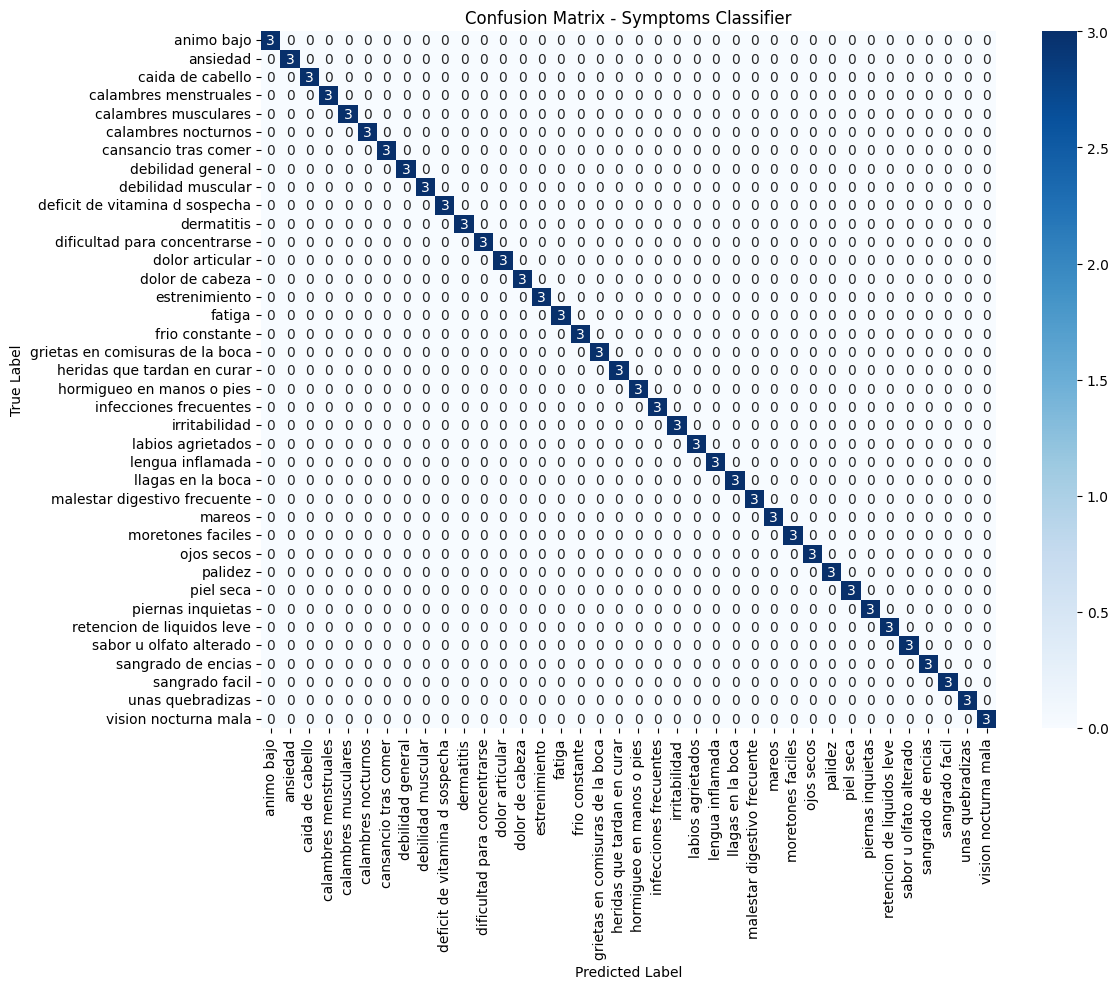

In [77]:
# Con el siguiente código obtenemos la matriz de confusión
pred_output = trainer.predict(dataset["test"])
y_true = pred_output.label_ids
y_pred = np.argmax(pred_output.predictions, axis=1)
cm = confusion_matrix(y_true, y_pred, labels=range(len(all_symptoms)))

print("Resultado de clasificaciones")
print(classification_report(y_true, y_pred, target_names=all_symptoms, zero_division=0))

# Gráfico con seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=all_symptoms,
            yticklabels=all_symptoms)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Symptoms Classifier')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 3.2) Segundo entrenamiento con división aleatoria

En este apartado, realizaremos el mismo proceso de entrenamiento que la sección "3.1) Primer entrenamiento con división estratificada" pero utilizamos las divisiones aleatorias en lugar de estratificadas

In [78]:
# 1) Mapeo de etiquetas (síntoma <-> id)
# --------------------------------------
all_symptoms = sorted(sintomas_df["sintoma"].unique())
sym2id = {sintoma:i for i,sintoma in enumerate(all_symptoms)}
id2sym = {i:sintoma for sintoma,i in sym2id.items()}

for df in (train_rand, test_rand, val_rand):
    df["label"] = df["sintoma"].map(sym2id).astype(int)   # single integer label


# 2) Construcción de DatasetDict y tokenización de set de datos
# -------------------------------------------------------------
tokenizer = AutoTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')

dataset = DatasetDict({
    "train": Dataset.from_pandas(train_rand[['texto', 'label']].rename(columns={"texto":"text"})),
    "validation": Dataset.from_pandas(val_rand[['texto', 'label']].rename(columns={"texto":"text"})),
    "test": Dataset.from_pandas(test_rand[['texto', 'label']].rename(columns={"texto":"text"})),
})

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=256)

dataset = dataset.map(tokenize, batched=True)
dataset = dataset.remove_columns(["text"])
dataset.set_format(type="torch")

# 3) Modelo de clasificación
# --------------------------
num_labels = len(all_symptoms)
model_NLP = AutoModelForSequenceClassification.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased', num_labels=num_labels
)

# 4) Métricas de evaluación
# -------------------------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
        "precision_macro": precision_score(labels, preds, average="macro", zero_division=0),
        "recall_macro": recall_score(labels, preds, average="macro", zero_division=0),
    }

# 5) Configuración de entrenamiento
# ---------------------------------
args = TrainingArguments(
    output_dir=r"..\models\NLP\NLP runs - all random",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    logging_strategy="steps",
    logging_steps=1,
    num_train_epochs=10,
    weight_decay=0.01,
    eval_strategy="epoch",          
    save_strategy="epoch",
    load_best_model_at_end=True,      
    metric_for_best_model="eval_loss",        
    greater_is_better=False,
    fp16=True,
    seed=seed
)

trainer = Trainer(
    model=model_NLP,
    args=args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

# 6) Entrenamiento y evaluación
# -------------------------------
print("Entrenamiento en proceso")
trainer.train()
evaluate_results = trainer.evaluate(dataset["test"])
print("Evaluación test y métricas:", evaluate_results)

Map: 100%|██████████| 114/114 [00:00<00:00, 5351.97 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\oscar.xu\AppData\Local\Temp\ipykernel_22868\641981634.py:66: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Entrenamiento en proceso


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,3.541400,3.401136,0.164948,0.141723,0.183139,0.204955
2,2.927300,2.891763,0.587629,0.540226,0.573058,0.598246
3,2.213100,2.330068,0.814433,0.757855,0.813739,0.767568
4,2.286900,1.846946,0.886598,0.858718,0.880556,0.867593
5,1.218100,1.422409,0.927835,0.915146,0.940278,0.918519
6,1.317800,1.135969,0.927835,0.915146,0.940278,0.918519
7,0.960100,0.916937,0.969072,0.971519,0.980000,0.971429
8,0.845900,0.776407,0.989691,0.990204,0.992857,0.990476
9,0.646600,0.701129,0.989691,0.990204,0.992857,0.990476
10,0.661000,0.672693,0.989691,0.990204,0.992857,0.990476


Evaluación test y métricas: {'eval_loss': 0.6266190409660339, 'eval_accuracy': 0.9824561403508771, 'eval_f1_macro': 0.982456140350877, 'eval_precision_macro': 0.9868421052631579, 'eval_recall_macro': 0.9868421052631579, 'eval_runtime': 0.3047, 'eval_samples_per_second': 374.198, 'eval_steps_per_second': 13.13, 'epoch': 10.0}


Resultado de clasificaciones
                                 precision    recall  f1-score   support

                     animo bajo       1.00      1.00      1.00         5
                       ansiedad       1.00      1.00      1.00         6
               caida de cabello       1.00      1.00      1.00         2
          calambres menstruales       1.00      1.00      1.00         3
           calambres musculares       1.00      0.50      0.67         4
            calambres nocturnos       0.50      1.00      0.67         2
           cansancio tras comer       1.00      1.00      1.00         1
              debilidad general       1.00      1.00      1.00         2
             debilidad muscular       1.00      1.00      1.00         2
 deficit de vitamina d sospecha       1.00      1.00      1.00         4
                     dermatitis       1.00      1.00      1.00         4
   dificultad para concentrarse       1.00      1.00      1.00         3
                dolor

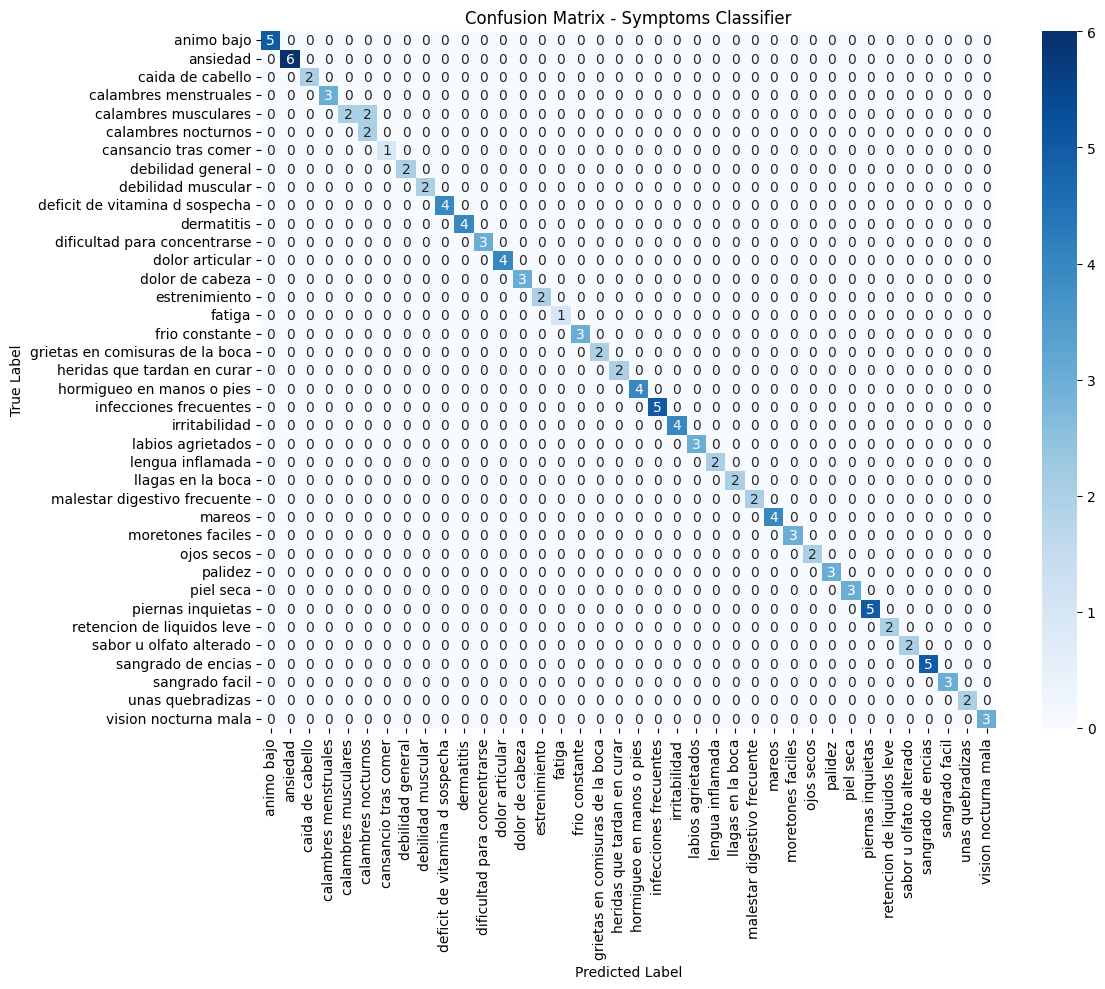

In [79]:
# Con el siguiente código obtenemos la matriz de confusión
pred_output = trainer.predict(dataset["test"])
y_true = pred_output.label_ids
y_pred = np.argmax(pred_output.predictions, axis=1)
cm = confusion_matrix(y_true, y_pred, labels=range(len(all_symptoms)))

print("Resultado de clasificaciones")
print(classification_report(y_true, y_pred, target_names=all_symptoms, zero_division=0))

# Gráfico con seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=all_symptoms,
            yticklabels=all_symptoms)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - Symptoms Classifier')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### 3.3) Evaluación de los modelos

`Conclusión general`. Independientemente de la estrategia split, ambos modelos alcanzan resultados muy altos con diferencias mínimas. No obstante, el estratificado ofrece una ligera ventaja y una convergencia algo más temprana.

`Similitudes`
- Ambos modelos logran alto rendimiento en pocas épocas.
- Métricas finales muy buenas (accuracy, F1, precision, recall).
- Generalización alta en el conjunto de test reportado.
- Posible fuga de datos (data leakage) por similitudes/ paráfrasis entre ejemplos en ambos modelos.

`Diferencias`
- El modelo de split aleatorio obtiene ligeramente mejor rendimiento (diferencia pequeña).
- El estratificado converge antes (a partir de época 6) mientras que el aleatorio se estabiliza más tarde (a partir de época 8).

Se observa que ambos modelos han obtenido muy buenos resultados en pocos epochs, con valores de métricas cercanos al 1. Esto puede ser una señal de que el modelo está prediciendo demasiado bien y puede que haya habido una fuga de datos (data leakage). Esto se debe a que:

- **Riesgo de fuga por paráfrasis y similitud.** El dataset incluye descripciones generadas y parafraseadas que pueden ser muy similares entre sí. Esto incrementa el riesgo de “fuga de información” entre train/validation/test dado que el modelo está entrenándose con descripciones similares a los que hay en la validación o test, inflando así las métricas.

- **Relevancia práctica.** No obstante, en nuestro caso de uso, se espera que las descripciones reales de usuarios se parezcan mucho a ejemplos del entrenamiento (patrones lingüísticos recurrentes como “me siento cansado todo el día”, “dolor menstrual intenso”, etc.). Por tanto, un alto rendimiento en escenarios con frases parecidas no es necesariamente "malo": refleja el comportamiento esperado en producción. A pesar de que cada uno puede expresarse de infinitas maneras, es muy probable que utilicen sinónimos, oraciones similares a los utilizados en el entrenamiento, por lo que es inevitable que haya cierto grado de data leakage.

Dado que con el split aleatorio se han obtenido métricas ligeramente mejores, lo guardamos como el mejor modelo obtenido para utilizarlo posteriormente.

In [ ]:
best_ckpt = trainer.state.best_model_checkpoint
print("Best checkpoint:", best_ckpt)

export_dir = r"..\models\NLP\NLP best model"
os.makedirs(export_dir, exist_ok=True)
trainer.save_model(export_dir)          # Guardamos modelo + config 
tokenizer.save_pretrained(export_dir)   # Guardamos el tokenizador

pd.Series(sym2id).to_json(
    os.path.join(export_dir, "symptom2id.json"),
    force_ascii=False
)

Best checkpoint: ..\models\NLP\NLP runs - all random\checkpoint-350


## 4) Prueba de predicción con oraciones nuevas

En esta última sección, simularemos ser el usuario real del modelo e intentamos utilizar nuevas descripciones para ver si el modelo funciona de forma esperado con alto rendimiento. Dado que previamente hemos identificado posibilidad de fuga de datos, aquí realizamos una prueba empírica de si el modelo sería capaz de predecir bien los síntomas.

In [82]:
# Cargar el mejor modelo guardado y tokenizador
model_dir = r"..\models\NLP\NLP best model"
model = AutoModelForSequenceClassification.from_pretrained(model_dir)
tokenizer = AutoTokenizer.from_pretrained(model_dir)

# Cargar el archivo de mapeo
with open(f"{model_dir}/symptom2id.json", "r", encoding="utf-8") as f:
    sym2id = json.load(f)
id2sym = {int(v): k for k, v in sym2id.items()}

In [ ]:
def predict_symptom(texts):
    """
    Esta función permite utilizar el modelo y predecir el síntoma más probable para una descripción de texto y devuelve el síntoma (etiqueta predecida) y su confianza.

    Parámetros
    ----------
    texts: Descripción o lista de descripciones que el usuario introducirá como input. 

    Requerimientos
    ---------
    Requiere que existan:
    - `model`     : el modelo con el cual se va a predecir instanciado
    - `tokenizer` : tokenizer compatible con el modelo
    - `id2sym`    : dict que mapea id de clase (int) -> nombre de síntoma (str).

    Devuelve
    --------
    Lista de resultados, uno por texto de entrada, con las claves:
        - "text"          : texto original (el que introduce el usuario)
        - "pred_symptom"  : etiqueta predicha según `id2sym`
        - "confidence"    : probabilidad de la clase predicha en [0, 1]
        
    Ejemplo
    -------
    >>> predict_symptom("Últimamente me siento muy cansado todo el día")
    [{'text': 'Últimamente me siento muy cansado todo el día',
      'pred_symptom': 'Fatiga',
      'confidence': 0.93}]
    """
    
    if isinstance(texts, str):
        texts = [texts]
    inputs = tokenizer(texts, return_tensors="pt", truncation=True, padding=True, max_length=256)
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        pred_ids = np.argmax(probs, axis=1)
    results = []
    for t, pid, pvec in zip(texts, pred_ids, probs):
        results.append({"text": t, "pred_symptom": id2sym[pid], "confidence": float(pvec[pid])})
    return results


[{'text': 'Últimamente mi cabeza me duele muchísimo diariamente', 'pred_symptom': 'dolor de cabeza', 'confidence': 0.3047117292881012}]


A continuación, probaremos una cantidad de frases nuevas para verificar el funcionamiento correcto del modelo:

In [88]:
# Lista de frases para probar
frases_prueba = [
    "Últimamente me siento agotado todo el día aunque duerma bien.",
    "Tengo cólicos muy fuertes cada mes antes de mi periodo.",
    "Mi piel está áspera y se descama con facilidad.",
    "Se me está cayendo mucho el cabello desde hace unas semanas.",
    "Estoy constantemente triste y no le encuentro alegría a las cosas.",
    "Siento que no tengo mucha fuerza en los brazos",
    "El dolor menstrual me impide hacer mis actividades diarias.",
    "La piel de mis manos está seca y agrietada.",
    "Cada vez que me cepillo el pelo, se me queda un montón en el cepillo.",
    "Me siento débil y sin fuerzas incluso después de descansar.",
    "Estos días, da igual lo que coma me sienta super pesado y tengo el estómago como revuelto.",
    "Últimamente tengo los labios muy secos a todas horas",
    "Me cuesta bastente ir al baño"
]

# Ejecutar predicciones
resultados = predict_symptom(frases_prueba)

# Mostrar resultados
for r in resultados:
    print(f"Texto: {r['text']}")
    print(f"Predicción: {r['pred_symptom']} (confianza: {r['confidence']:.2f})")
    print("-" * 50)


Texto: Últimamente me siento agotado todo el día aunque duerma bien.
Predicción: fatiga (confianza: 0.32)
--------------------------------------------------
Texto: Tengo cólicos muy fuertes cada mes antes de mi periodo.
Predicción: calambres menstruales (confianza: 0.26)
--------------------------------------------------
Texto: Mi piel está áspera y se descama con facilidad.
Predicción: piel seca (confianza: 0.60)
--------------------------------------------------
Texto: Se me está cayendo mucho el cabello desde hace unas semanas.
Predicción: caida de cabello (confianza: 0.67)
--------------------------------------------------
Texto: Estoy constantemente triste y no le encuentro alegría a las cosas.
Predicción: animo bajo (confianza: 0.30)
--------------------------------------------------
Texto: Siento que no tengo mucha fuerza en los brazos
Predicción: debilidad muscular (confianza: 0.38)
--------------------------------------------------
Texto: El dolor menstrual me impide hacer mis

Podemos ver que si no se usan las palabras clave, el modelo tiene más baja confianza pero de momento siempre acierta el síntoma.